In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

from models.sub_cos_glm import Sub_Cos_GLM
from models.tcn import TCN

In [2]:
cos_basis_no = 24
scale = 6
shift = 1
        
kern_basis = torch.zeros(cos_basis_no, 500)
for i in range(cos_basis_no):
    phi = 1.5707963267948966*i
    xmin = phi - 3.141592653589793
    xmax = phi + 3.141592653589793

    x_in = torch.arange(0, 500, 1)
    raw_cos = scale  * torch.log(x_in + shift + 1e-7)

    basis = 0.5*torch.cos(raw_cos - phi) + 0.5
    basis[raw_cos < xmin] = 0.0
    basis[raw_cos > xmax] = 0.0
    kern_basis[i] = basis

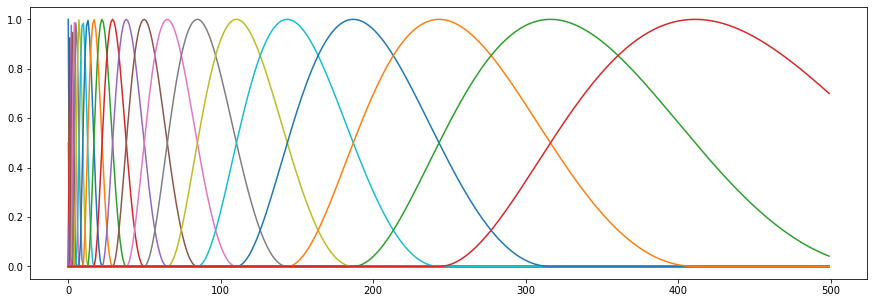

In [3]:
plt.figure(figsize = (15,5))
for i in range(cos_basis_no):
    plt.plot(kern_basis[i])

# Hyperparameters

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60_noNA"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
#V_file = "V_diff.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
V -= torch.mean(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)

part_C_syn_e = np.load("/media/hdd01/sklee/CA1_clust4-60/data/handsub6_C_syn_e.npy")
part_C_syn_i = np.load("/media/hdd01/sklee/CA1_clust4-60/data/handsub6_C_syn_i.npy")
part_C_syn_e = torch.from_numpy(part_C_syn_e)
part_C_syn_i = torch.from_numpy(part_C_syn_i)

In [3]:
T_train = 996 * 1000 * 50
T_test = 1 * 1000 * 50
H_no = 1
sub_no = 10
two_nonlin = False
#layer_no = 4
E_no = 2000
I_no = 200
T_no = 500
device = torch.device("cuda")

batch_length = 50000
batch_size = 6
iter_no = 9960*2
epoch_no = iter_no*batch_length*batch_size//T_train 

# Preprocess

In [6]:
V_train = V[:T_train].float()
V_test = V[-50000:].to(device).float()

test_E_neural = E_neural[-50000:].toarray()
test_I_neural = I_neural[-50000:].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [7]:
"""
C_syn_e = torch.zeros(sub_no, E_no).to(device)
C_syn_i = torch.zeros(sub_no, I_no).to(device)

for i in range(E_no):
    den = eloc[i,0]
    if den == den_idx[0]:
        C_syn_e[0,i] = 1
    elif den == den_idx[1]:
        C_syn_e[1,i] = 1
    elif den == den_idx[2]:
        C_syn_e[2,i] = 1
    elif den == den_idx[3]:
        C_syn_e[3,i] = 1

for i in range(I_no):
    den = iloc[i,0]
    if den == den_idx[0]:
        C_syn_e[0,i] = 1
    elif den == den_idx[1]:
        C_syn_e[1,i] = 1
    elif den == den_idx[2]:
        C_syn_e[2,i] = 1
    elif den == den_idx[3]:
        C_syn_e[3,i] = 1
"""

'\nC_syn_e = torch.zeros(sub_no, E_no).to(device)\nC_syn_i = torch.zeros(sub_no, I_no).to(device)\n\nfor i in range(E_no):\n    den = eloc[i,0]\n    if den == den_idx[0]:\n        C_syn_e[0,i] = 1\n    elif den == den_idx[1]:\n        C_syn_e[1,i] = 1\n    elif den == den_idx[2]:\n        C_syn_e[2,i] = 1\n    elif den == den_idx[3]:\n        C_syn_e[3,i] = 1\n\nfor i in range(I_no):\n    den = iloc[i,0]\n    if den == den_idx[0]:\n        C_syn_e[0,i] = 1\n    elif den == den_idx[1]:\n        C_syn_e[1,i] = 1\n    elif den == den_idx[2]:\n        C_syn_e[2,i] = 1\n    elif den == den_idx[3]:\n        C_syn_e[3,i] = 1\n'

In [8]:

C_syn_e = torch.zeros(sub_no, E_no).to(device)
C_syn_e[:6] = part_C_syn_e

C_syn_i = torch.zeros(sub_no, I_no).to(device)
C_syn_i[:6] = part_C_syn_i

for i in range(E_no):
    den = eloc[i,0]
    if den == den_idx[0]:
        C_syn_e[:,i] = 0
        C_syn_e[6,i] = 1
    elif den == den_idx[1]:
        C_syn_e[:,i] = 0
        C_syn_e[7,i] = 1
    elif den == den_idx[2]:
        C_syn_e[:,i] = 0
        C_syn_e[8,i] = 1
    elif den == den_idx[3]:
        C_syn_e[:,i] = 0
        C_syn_e[9,i] = 1

for i in range(I_no):
    den = iloc[i,0]
    if den == den_idx[0]:
        C_syn_e[:,i] = 0
        C_syn_e[6,i] = 1
    elif den == den_idx[1]:
        C_syn_e[:,i] = 0
        C_syn_e[7,i] = 1
    elif den == den_idx[2]:
        C_syn_e[:,i] = 0
        C_syn_e[8,i] = 1
    elif den == den_idx[3]:
        C_syn_e[:,i] = 0
        C_syn_e[9,i] = 1
        
C_den = torch.zeros(sub_no, sub_no).to(device)
C_den[0,1:] = 1


# Train

In [9]:
model = Sub_Cos_GLM(C_syn_e, C_syn_i, T_no, H_no, two_nonlin, device)
#model = TCN(C_syn_e, C_syn_i, T_no, H_no, layer_no, device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.005) # For TCN / Sub TCN


model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

2701


In [10]:
score_list = []

for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    V_pred = model(batch_E_neural, batch_I_neural)
    
    loss = torch.mean((V_pred - batch_V)**2)
    loss.backward()
    optimizer.step()
    #scheduler.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred = model(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0))
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test-test_V_pred)**2).item()
        score_list.append(test_score)
                
        print(i, np.round(test_score,6),
              np.round(test_mse,6))


<ipython-input-10-70f3833c2737>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 0.159641 1.567936
49 0.601231 0.743666
99 0.710122 0.548349
149 0.799317 0.380073
199 0.854324 0.276931
249 0.897619 0.195496
299 0.918827 0.151382
349 0.931354 0.132409
399 0.936444 0.121317
449 0.940756 0.146906
499 0.946196 0.107088
549 0.947886 0.110341
599 0.949224 0.10158
649 0.953843 0.086486
699 0.956054 0.082218
749 0.957938 0.079036
799 0.954368 0.094921
849 0.959298 0.076889
899 0.958992 0.091983
949 0.96086 0.073678
999 0.961678 0.086188
1049 0.960958 0.076129
1099 0.96321 0.069466
1149 0.963542 0.078666
1199 0.963424 0.069856
1249 0.964173 0.076531
1299 0.963782 0.069732
1349 0.964971 0.065541
1399 0.964824 0.066493
1449 0.96496 0.072247
1499 0.965921 0.064212
1549 0.966148 0.064988
1599 0.966042 0.064026
1649 0.966333 0.064769
1699 0.965982 0.064021
1749 0.966863 0.062997
1799 0.966776 0.068768
1849 0.967107 0.062773
1899 0.966879 0.06484
1949 0.966692 0.063388
1999 0.967355 0.061013
2049 0.967651 0.084634
2099 0.967196 0.061456
2149 0.966361 0.093513
2199 0.968022 0.06

KeyboardInterrupt: 

In [11]:
kern_basis = torch.zeros(24, T_no).to(device)
for i in range(24):
    phi = 1.5707963267948966*i
    xmin = phi - 3.141592653589793
    xmax = phi + 3.141592653589793

    x_in = torch.arange(0, T_no, 1)
    raw_cos = 6  * torch.log(x_in + 1 + 1e-7)

    basis = 0.5*torch.cos(raw_cos - phi) + 0.5
    basis[raw_cos < xmin] = 0.0
    basis[raw_cos > xmax] = 0.0
    kern_basis[i] = basis
    
kern_e = torch.matmul(model.W_e_layer1, kern_basis)
kern_i = torch.matmul(model.W_i_layer1, kern_basis)
kern_e = kern_e.cpu().detach().numpy()
kern_i = kern_i.cpu().detach().numpy()

scale_e = model.E_scale.cpu().detach().numpy()
scale_i = model.I_scale.cpu().detach().numpy()

print(kern_e.shape)
print(kern_i.shape)
print(scale_e.shape)
print(scale_i.shape)

(10, 500)
(10, 500)
(2000,)
(200,)


In [11]:
torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60/glm_nona_s10_h1.pt")

#np.save("/media/hdd01/sklee/CA1_clust4-60/glm_diff_s10_h2_output.npy", test_V_pred.cpu().detach().numpy().flatten())

np.savez("/media/hdd01/sklee/CA1_clust4-60/glm_nona_s10_h1_output.npz",
         test = test_V_pred.cpu().detach().numpy().flatten(),
         kern_e = kern_e,
         kern_i = kern_i,
         scale_e = scale_e,
         scale_i = scale_i)

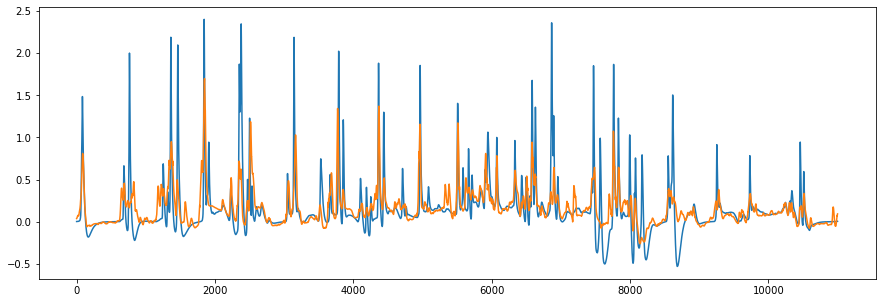

In [10]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[17000:28000])
plt.plot(test_V_pred.cpu().detach().numpy()[17000:28000])

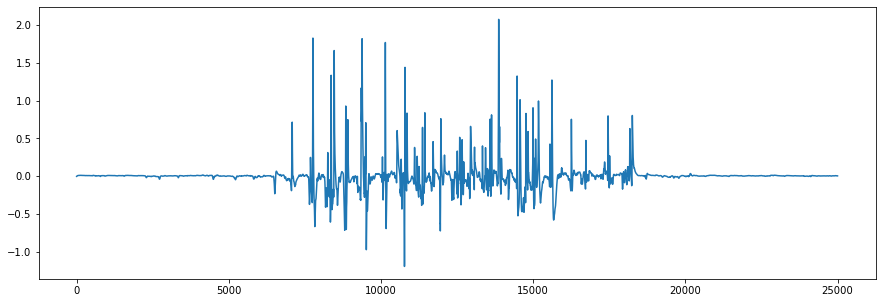

In [11]:
resid = V_test - test_V_pred

plt.figure(figsize = (15,5))
plt.plot(resid.cpu().detach().numpy()[10000:35000])

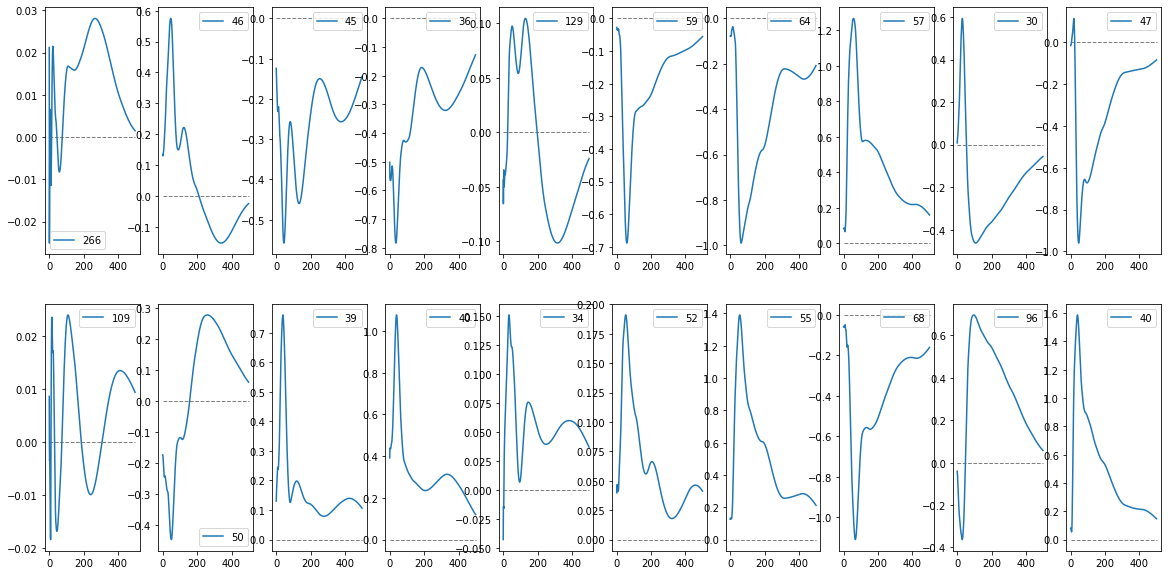

In [12]:
fig, axs = plt.subplots(nrows = H_no, ncols= sub_no, figsize = (20,10))

for i in range(H_no):
    for j in range(sub_no):
        idx = j*H_no + i
        max_t = np.argmax(np.abs(kern_e[idx]))
        axs[i,j].plot(kern_e[idx], label=str(max_t))
        axs[i,j].hlines(y=0, xmin=0, xmax=T_no, linewidth=1, linestyle="--", color="gray")
        axs[i,j].legend()

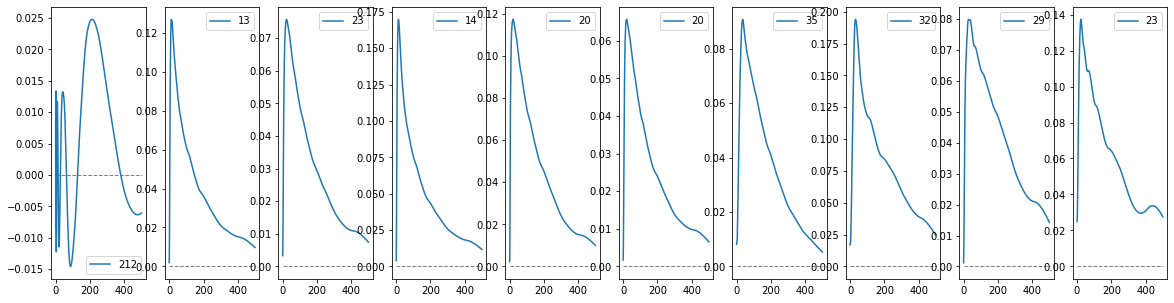

In [15]:
fig, axs = plt.subplots(nrows = H_no, ncols= sub_no, figsize = (20,5))

for i in range(H_no):
    for j in range(sub_no):
        idx = j*H_no + i
        max_t = np.argmax(np.abs(kern_e[idx]))
        axs[j].plot(kern_e[idx], label=str(max_t))
        axs[j].hlines(y=0, xmin=0, xmax=T_no, linewidth=1, linestyle="--", color="gray")
        axs[j].legend()

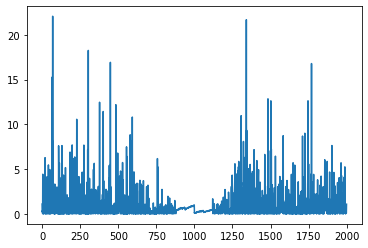

In [14]:
plt.plot(np.exp(model.E_scale.cpu().detach().numpy()))